In [16]:
import pandas as pd
import sqlite3
import zipfile
from  pandasql import sqldf
from matplotlib import pyplot as plt


In [17]:
tn_movie = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')



tn_movie = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
tn_movie

# remove all $ and commas for domestic gross, worldwide gross, and production budget

tn_movie["production_budget"]=tn_movie["production_budget"].map(lambda x: int(x.replace(',', '').replace('$', '')))
tn_movie["domestic_gross"]=tn_movie["domestic_gross"].map(lambda x: int(x.replace(',', '').replace('$', '')))
tn_movie["worldwide_gross"]=tn_movie["worldwide_gross"].map(lambda x: int(x.replace(',', '').replace('$', '')))


#Add ROI column
tn_movie["ROI"]= (tn_movie["worldwide_gross"]- tn_movie["production_budget"])/    \
         tn_movie["production_budget"]

#Add start year as int column

tn_movie["start_year"] = tn_movie["release_date"].map(lambda x: int(x[-4:]))

#eliminate any worldwide gross columns that = 0

tn_movie = tn_movie [tn_movie .worldwide_gross != 0]

# tn_movie

In [9]:

conn = sqlite3.connect('zippedData/im.db')
cur= conn.cursor()
# cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""").fetchall()

In [10]:
q1 = """SELECT * FROM movie_basics ;"""
dfzip=pd.read_sql(q1, conn)
imdb_basics = pd.merge(left= dfzip ,right = tn_movie, left_on=["start_year","primary_title"], \
                       right_on=["start_year","movie"], \
                          how = 'inner')
# imdb_basics

# Goal 2 - Writer and Driector Profitablity


# Director Profitablity/ROI

In [35]:
movie_to_director = """
SELECT mb.primary_title AS title, 
    mb.start_year,
    p.primary_name as director_name,
    p.death_year as dead

    
FROM movie_basics AS mb 
JOIN directors AS d 
    ON d.movie_id = mb.movie_id 
JOIN persons as p
    ON p.person_id= d.person_id
JOIN movie_akas AS a
    ON mb.movie_id = a.movie_id 
    

ORDER BY primary_title ASC;"""

In [46]:
directors = pd.read_sql(movie_to_director, conn)
directors = directors.drop_duplicates() 

In [55]:
d_info_all = pd.merge(left= tn_movie, right = directors, how = "inner", left_on=["start_year","movie"],\
                  right_on=["start_year","title"])

#Filter out the dead and lower mid budget (less than $10 mil)
dia = d_info_all[(d_info_all["dead"].isna()) & (d_info_all["production_budget"]>= 10000000)]

#Give us the column we want
dia2 = dia[["movie", "ROI", "director_name"]]
dia2.sort_values(by = ["ROI"], ascending = False)

,movie,ROI,director_name
1077,The Fault in Our Stars,24.597236,Josh Boone
1124,Halloween,24.490067,David Gordon Green
1048,Black Swan,24.482055,Darren Aronofsky
868,La La Land,20.317558,Damien Chazelle
1002,Annabelle: Creation,19.358991,David F. Sandberg
...,...,...,...
779,Accidental Love,-0.994791,David O. Russell
670,Freaks of Nature,-0.997850,Robbie Pickering
524,Foodfight!,-0.998362,Lawrence Kasanoff
1108,10 Days in a Madhouse,-0.998782,Timothy Hines


## Getting the mean ROI to determine the directors' average ROI as many have done high and low budget films.

In [56]:
d_roi = dia2.groupby(['director_name']).mean().sort_values(by=["ROI"], ascending = False)
d_roi


,ROI
director_name,
Josh Boone,24.597236
John Krasinski,18.677782
Adam Robitel,15.788559
Andy Muschietti,13.900204
Kyle Balda,13.738294
...,...
David Hayter,-0.994725
Robbie Pickering,-0.997850
Lawrence Kasanoff,-0.998362


''

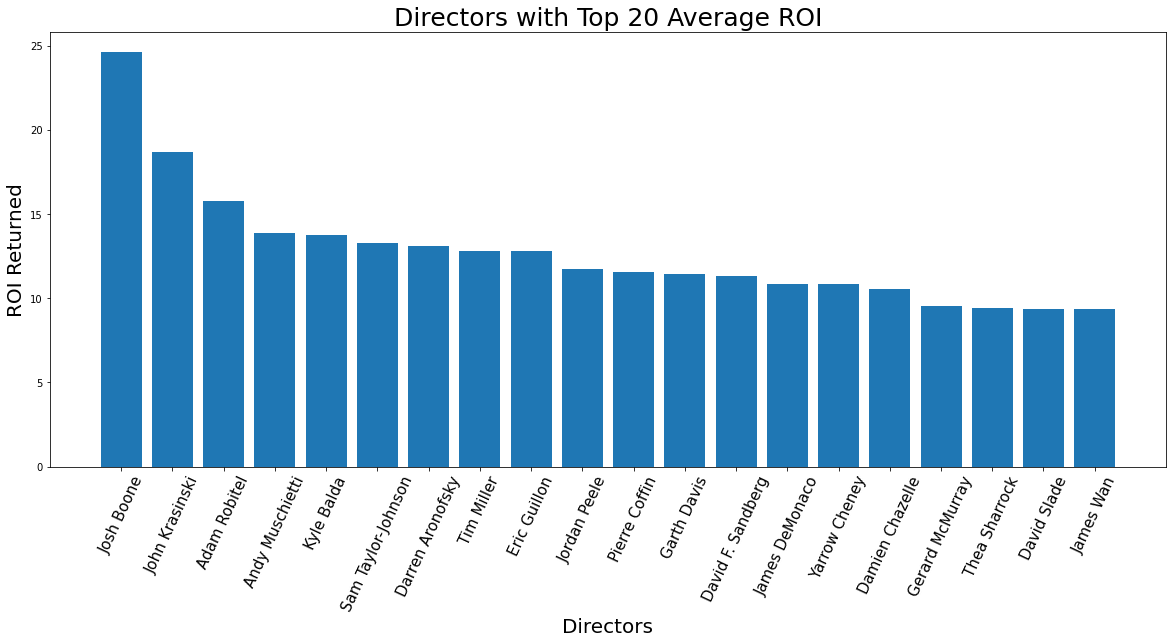

In [65]:
fig, ax = plt.subplots(figsize = (20,8))

d_roi2 = d_roi.head(20)

ax.bar(
    x=d_roi2.index,
    height=d_roi2["ROI"]
)
plt.xticks(fontsize = 15, rotation = 65)
ax.set_title("Directors with Top 20 Average ROI", fontsize = 25)
ax.set_xlabel("Directors", fontsize =20)
ax.set_ylabel("ROI Returned", fontsize =20)
# plt.savefig('director_roi.png')
;

# Writer Profitablity/ROI

In [50]:
movie_to_writer = """
SELECT mb.primary_title AS title,
    mb.start_year,
    w.person_id, 
    p.primary_name as writer_name,
    p.death_year as dead
    
FROM movie_basics AS mb 
JOIN writers AS w 
    ON mb.movie_id = w.movie_id 
JOIN persons as p
    ON p.person_id= w.person_id


ORDER BY primary_title ASC;"""


In [51]:
writers = pd.read_sql(movie_to_writer, conn)
writers = writers.drop_duplicates() 

In [58]:
w_info_all = pd.merge(left= imdb_basics, right = writers, how = "inner", left_on=["movie", "start_year"],\
                  right_on=["title", "start_year"])

#Filter out the dead and lower - mid budget (less than $10 mil)
wia = w_info_all[(w_info_all["dead"].isna()) & (w_info_all["production_budget"]>= 10000000)]

#Give us the column we want
wia2 = wia[["movie", "ROI", "writer_name"]]
wia2.sort_values(by = ["ROI"], ascending = False)

,movie,ROI,writer_name
2783,The Fault in Our Stars,24.597236,Scott Neustadter
2782,The Fault in Our Stars,24.597236,Michael H. Weber
2781,The Fault in Our Stars,24.597236,John Green
1318,Halloween,24.490067,Danny McBride
1315,Halloween,24.490067,John Carpenter
...,...,...,...
2,Foodfight!,-0.998362,Lawrence Kasanoff
0,Foodfight!,-0.998362,Sean Catherine Derek
3129,10 Days in a Madhouse,-0.998782,Timothy Hines
2730,Broken Horses,-0.999769,Abhijat Joshi


## Getting the mean ROI to determine the writers' average ROI. Many have written highly profitable as many have done high and low budget films.

In [59]:
w_roi = wia2.groupby(['writer_name']).mean().sort_values(by=["ROI"], ascending = False)
w_roi 

,ROI
writer_name,
Jeff Fradley,24.490067
David Gordon Green,24.490067
Mark Heyman,24.482055
Andres Heinz,24.482055
Damien Chazelle,20.317558
...,...
Joshua Wexler,-0.998362
Rebecca Swanson,-0.998362
Timothy Hines,-0.998782


''

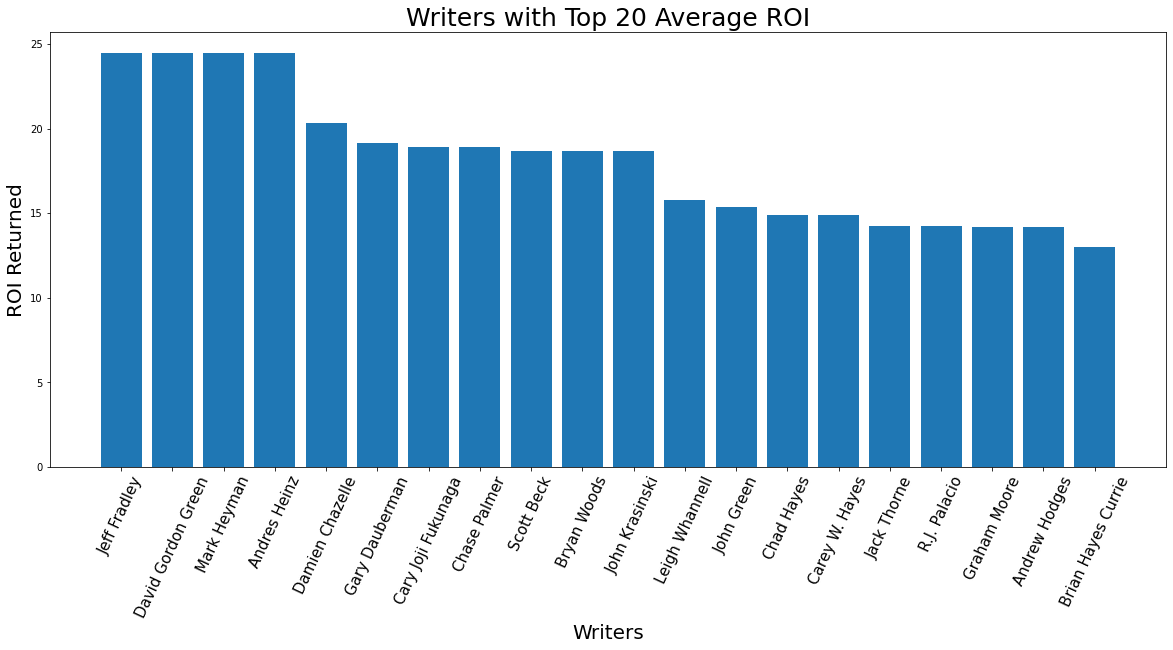

In [60]:
fig, ax = plt.subplots(figsize = (20,8))

w_roi2 = w_roi.head(20)  #

ax.bar(
    x=w_roi2.index,
    height=w_roi2["ROI"]
)
ax.set(title = "Writers with Top 20 ROI", xlabel = "Writers", ylabel = "ROI Returned")
plt.xticks(fontsize = 15, rotation = 65)
ax.set_title("Writers with Top 20 Average ROI", fontsize = 25)
ax.set_xlabel("Writers", fontsize =20)
ax.set_ylabel("ROI Returned", fontsize =20)
# plt.savefig('writer_roi.png')
;

# Appendix: 

#### Is critical reception correlated to ROI? Worldwide Gross? Domestic Gross?

In [61]:
mb_to_ratings = """
SELECT mb.primary_title AS title,
    mb.start_year,
    rt.averagerating,
    rt.numvotes
    
FROM movie_basics AS mb 
JOIN movie_ratings AS rt
    ON mb.movie_id = rt.movie_id 

ORDER BY rt.numvotes DESC;"""

movie_ratings = pd.read_sql(mb_to_ratings, conn)

In [62]:
crit_rate = movie_ratings[(movie_ratings["numvotes"]>= 50000)]
#Preventing low rating numbers from affecting results
    
    
crit_all = pd.merge(left= imdb_basics, right = crit_rate, how = "inner", left_on=["movie", "start_year"],\
                  right_on=["title", "start_year"])

crit_use_unsort = crit_all[["title","production_budget","domestic_gross", "worldwide_gross", "ROI", \
                            "averagerating", "numvotes" ]]

crit_use_unsort2=crit_use_unsort[(crit_use_unsort["production_budget"] >= 10000000)] 
#Filtering data further by only looking at movies with production budgets of $10 million or more

crit_use = crit_use_unsort2.sort_values(by = ["averagerating"], ascending = False)
crit_use

,title,production_budget,domestic_gross,worldwide_gross,ROI,averagerating,numvotes
253,Inception,160000000,292576195,835524642,4.222029,8.8,1841066
55,Interstellar,165000000,188017894,666379375,3.038663,8.6,1299334
759,Avengers: Infinity War,300000000,678815482,2048134200,5.827114,8.5,670926
471,Django Unchained,100000000,162805434,449948323,3.499483,8.4,1211405
613,Coco,175000000,209726015,798008101,3.560046,8.4,277194
...,...,...,...,...,...,...,...
114,The Legend of Hercules,70000000,18848538,58953319,-0.157810,4.2,50352
599,Fifty Shades of Grey,40000000,166167230,570998101,13.274953,4.1,279126
80,The Last Airbender,150000000,131772187,319713881,1.131426,4.1,137734
50,Jack and Jill,79000000,74158157,150519217,0.905307,3.3,71361


''

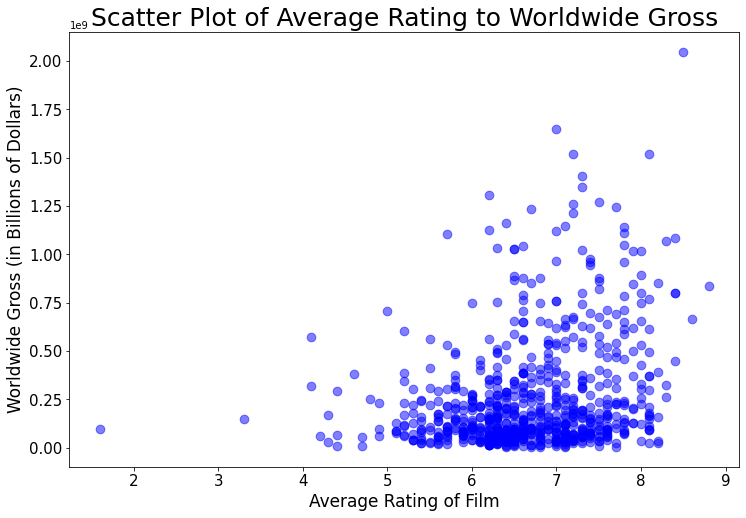

In [64]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))

rate = crit_use["averagerating"]
wwgross = crit_use["worldwide_gross"]
dgross = crit_use["domestic_gross"]
roi = crit_use["ROI"]


ax.scatter(x = rate, y =wwgross,  s = 75, color = "blue", alpha = .5)



plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_title("Scatter Plot of Average Rating to Worldwide Gross", fontsize = 25)
ax.set_xlabel("Average Rating of Film", fontsize =17)
ax.set_ylabel("Worldwide Gross (in Billions of Dollars)", fontsize =17)
# plt.savefig('rate_avg_to_gross')
;



In [450]:
correlation_roi = rate.corr(roi)
correlation_ww = rate.corr(wwgross)
correlation_d = rate.corr(dgross)

print("Person Correslation between average critical rating and ROI is: ", correlation_roi)
print("Person Correslation between average critical rating and worldwide gross is: ", correlation_ww)
print("Person Correslation between average critical rating and domestic gross is: ", correlation_d)


Person Correslation between average critical rating and ROI is:  0.1569574217794212
Person Correslation between average critical rating and worldwide gross is:  0.24975286953759598
Person Correslation between average critical rating and domestic gross is:  0.2829230120968297


#### So there is a positve correlation between critcal rating and ROI/Worldwide gross/domestic gross but its not a high/significant result.

# BUT WHO IS THE LOW BUDGET KING/QUEEN?

# Future
### Look into the ROI for actors/actresses to help narrow down casting
### Narrow down writers by region/language to get even more relevant results
### Figure out if runtime affects profitability 
### Track if a directors ROI can be predicted through modeling (ex. If certain director is given budget X, the ROI will most likely be in Y range
### Create a program that you can enter one or more of several variables, and will output ideal director/writer/time of release/etc. based on your input

### Look into the ROI for actors/actresses to help narrow down casting


# ACTOR/ACTRESS ROI

In [251]:
# movie_to_principals = """
# SELECT mb.primary_title AS title,
#     mb.start_year,
#     prin.person_id, 
#     p.primary_name as name,
#     p.primary_profession,
#     p.death_year as dead,
#     a.region

    
# FROM movie_basics AS mb 
# JOIN principals AS prin
#     ON prin.movie_id = mb.movie_id 
# JOIN persons as p
#     ON p.person_id= prin.person_id
# JOIN movie_akas AS a
#     ON mb.movie_id = a.movie_id 
    


# ORDER BY primary_title ASC;"""

# mov2prin = pd.read_sql(movie_to_principals, conn)



In [252]:
# mov2prin["primary_profession"] = mov2prin["primary_profession"].map(lambda x : str(x).split(","))
# 

In [ ]:
# mov2prin[y in ["actor", "actress"], for y in (mov2prin["primary_profession"] )]

In [312]:
# mov2prin[mov2prin["primary_profession"].map(lambda x : mov2prin["primary_profession"][x] == "actor" )]